# Course Two: Data Preparation

Expected time to complete: 45 minutes

## Goal of this Course

In this course we will transform our dataset into a format that can be used with a statistical model. We will first explain some key concepts that will help us to understand in which scope our problem stands.  

The course is split into the following parts:
- <a href='#context'>Context</a> 
- <a href='#supervised_vs_unsupervised'>Supervised vs Unsupervised Learning</a>
- <a href='#classif_vs_reg'>Classification vs Regression</a>
- <a href='#model_output'>Model Output</a> 
    - <a href='#load_data'>Load the Data</a>
    - <a href='#define_target'>Define our Target</a>
    - <a href='#basic_statistics'>Descriptive Statistics</a>


- <a href='#model_input'>Model Input</a> 
    - <a href='#feature_selection'>Feature Selection</a>
    - <a href='#basic_statistics2'>Descriptive Statistics</a>


- <a href='#pair_input_output'>Pair Model Input with Model Output</a> 
- <a href='#missing_data'>Check for Missing Data</a> 

<a id='context'></a>
# Context

In the previous tutorial we formulated a data problem, chose a dataset and performed some initial steps that cleaned  and then helped us explore the structure of our data. In this second course we will start looking at how to _prepare_ our dataset to be compatible with the kind of statistical models that can help us solve our problem.

Data preparation or __data wrangling__ is a crucial step in the modelling process. It refers to how we create a dataset to be ingested into at least one of the many statistical models at our disposal. 

We need to make sure we understand the scope of the problem:
- Do we have a _target_ variable? In other words, will our model predict something - the target - or will it look for unlabeled structure? (supervised vs unsupervised models)
- If predicting, what will the prediction target be like? Is it represented as discrete categories or a linear scale (classification or regression)?
- If predicting, what is the granularity? User level? User x time level?
- What features of our dataset are we going to use as input to our model (feature selection)?

Before we dive back into the code, let's explain a few core concepts that will be helpful to understand before we go any further.

<a id='supervised_vs_unsupervised'></a>
# Supervised vs Unsupervised Learning

An important disctinction to make when preparing your data for analysis is whether your problem is suitable for “supervised” or “unsupervised” learning models. 
 
__Unsupervised learning__ models receive input (_explanatory/predictor/independent_ variables or _features_) but no output (or _dependent/target_ variable)  and, essentially, are a way of discovering latent structure in a set of data (clustering is an example of unsupervised learning). Unsupervised models are very useful when working with unlabelled datasets. These models can then be (and often are) combined with supervised models.
 
__Supervised learning__ models, essentially,  learn a mathematical function between an input (_explanatory/predictor/independent_ variables) and an output (the _dependent/target_ variable). These models are used in situations where you know what you want to predict and have explicit input-output pairs for your model to be trained upon.

In our current project we want to forecast the minutes watched on iPlayer (output or _target_ variable) based on past behavior (input or _explanatory/predictor/independent_ variables). We have input-output pairs and are, therefore, in the supervised learning framework.

<a id='classif_vs_reg'></a>
# Classification vs Regression

Within the supervised learning class of problems there is a further split, based upon the nature of the target variable: discrete or linear. If a dataset is being used to predict one of a finite set of categories, this is called a classification problem and is tackled by a specific set of models called __classifiers__. A simple example of a classification problem is a spam email filter where the text of the email must be classified as either legitimate or not. A further example, now of a multi-classification problem is for handwriting recognition, where a hand-written letter is classified as one of a set of 36 (26 letters and 10 digits).

Alternatively, some data problems require the prediction of linear or non-categorical variables. This class of problems is approached using a class of model called __regressors__. An example of a regression problem would be to predict the number of hits an article receives by analysing the contents of its headline.

In our current project we want to predict _whether or not_ a user watched any content within a two-week period (a classification problem), and we also want to know _how much_ content a user watched within a two-week period (a gregression problem). We will therefore be using both classifiers and regressors in this project.

<a id='model_output'></a>
# Model Output

<a id='load_data'></a>
## Load the Data
Now we read our data from the last course back in and check that it looks sensible.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

In [2]:
# Download our output dataset from course 1
data = pd.read_csv('iplayer_data_c1.csv')

# Check that it all looks how we expect it to.
data.head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre,hour,enriched_genre_hour,enriched_duration_mins,percentage_watched
0,cd2006,f6d3d8,a282ca,Factual,00:00:21,1486911129420_1,2017-02-12 14:51:24.544,20920.0,weekday_6,Afternoon,0.21,3,0.348667,Factual,14,Factual,0.21,1.0
1,cd2006,b8fbf2,e0480e,Comedy,00:01:51,1484864257965_1,2017-01-19 22:17:04.648,111285.0,weekday_3,Evening,1.51,1,1.854750,Comedy,22,Drama,1.51,1.0
2,cd2006,e2f113,933a1b,Factual,00:00:30,1487099603980_1,2017-02-14 19:12:36.667,29945.0,weekday_1,Evening,0.30,3,0.499083,Factual,19,Factual,0.30,1.0
3,cd2006,0e0916,b68e79,Entertainment,00:01:22,1484773546557_1,2017-01-18 21:05:11.466,82620.0,weekday_2,Evening,1.22,1,1.377000,Entertainment,21,Drama,1.22,1.0
4,cd2006,ca03b9,5d0813,Sport,00:01:37,1486911176609_1,2017-02-12 14:52:08.965,97444.0,weekday_6,Afternoon,1.37,3,1.624067,Sport,14,Factual,1.37,1.0


This should all look very familiar by now. When computing the distribution of our observations among the `twoweek` variable (Course 1 - _Exploratory data analysis_) we saw that we had roughly the same amount of data, except for week 0. Here, as it is not clear why it should have less data (meaning it may be a sign of something not being right), we decide to remove this group from all our subsequent analyses.

In [3]:
data=data[data['twoweek']>0]

In [4]:
data.twoweek.value_counts().sort_index()

1    67222
2    62112
3    60431
4    51941
5    55668
6    49941
7    51286
8    53410
Name: twoweek, dtype: int64

<a id='define_target'></a>
## Define our Target

In this section we will walk through the process of how to create the output of our model. This variable that supervised models predict is know as the _target variable, the output variable_ or the _dependent variable_.

In our project we want to __forecast the next two weeks behaviour__, so we need to aggregate our target metric for the last two weeks of data available, i.e. how many minutes, if any, of content did each individual audience member consume within `twoweek` 8. 

Our target variable will be different for our two different types of model:

- In our __regression model__ our target is the total minutes watched within the final two week period.

- In our __classification model__  our target is a binary or "dummy" variable (0 or 1), where we will forecast whether a user will watch iPlayer or not (total minutes watched > 0) within the final two week period.


### Regression Model

In our specific problem, we want to forecast what _individual_ users will do. Therefore, we need to pivot our dataset from an __events view__ to a __user view__,  to build both our target and features.

To calculate minutes watched for each audience member we create a pivot table. This process results in a table where each individual audience member is represented as a row and each column describes the total minutes watched for a given two-week period. As all the audience members who consumed no content during a given two-week period are represented as "NA" after this operation, we replace all NAs with zeros. 

In [5]:
# We need to compute the total minutes watched within twoweek 8 for each user
target_reg=pd.pivot_table(data,
                          values='min_watched',
                          index=['user_id'],
                          columns=['twoweek'],
                          aggfunc=sum)[8].reset_index()


# We fill the NAs with 0: corresponds to the users without observations for the last twoweek
# i.e. who didn't watch anything
target_reg=target_reg.fillna(0)
target_reg.head()

,user_id,8
0,0001c6,0.144833
1,000c1a,318.047633
2,001c53,1.980350
3,001d44,10.059067
4,002b2e,0.000000


### Classification Model

To calcualate our target variable for the classification model we simply replace all numbers from the minutes watched column that are above zero with 1. 

In [6]:
# We build the dummy variable based on the minutes watched on this twoweek
target_class=target_reg.copy()
target_class[8]=np.where(target_class[8]>0,1,0)
target_class.head()

,user_id,8
0,0001c6,1
1,000c1a,1
2,001c53,1
3,001d44,1
4,002b2e,0


<a id='basic_statistics'></a>
## Descriptive Statistics

Both for a quick sanity check and to have business insights related to engagement, we will compute some descriptive statistics on our target variables.

### Regression Output - minutes watched
First, let's have a look at the basic statistics for the minutes watched per user in the final two-week group.

In [7]:
# Basic statistics for a quantitative variable
target_reg.describe()

,8
count,9163.000000
mean,75.587856
std,273.673732
min,0.000000
25%,0.000000
50%,0.000000
75%,28.586458
max,10577.486900


Here we can see that on average the users watched 76mn on `twoweek` 8. The minutes watched aren't equally distributed among the users though as the median is equal to 0 and the standard error quite huge.

Let's plot the histogram to have a better idea of the distribution.

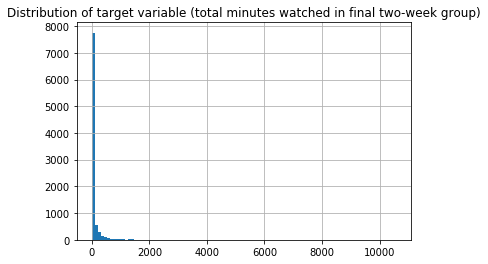

In [8]:
# Distribution of the minutes watched
target_reg[8].hist(bins=100)
plt.title('Distribution of target variable (total minutes watched in final two-week group)')
plt.show()

There are 100 bins and the scale reaches 10000 so each bar represents 100 minutes. This indicates the vast majority of people (represented as the first bar) consumed less than 100 minutes in the final two-week period.

### Classification Output - did the user watch iPlayer or not

Now let's have a look at the counts of the the classifier target variable. As expected, we see just zeros and ones, while it appears that there are more viewers that did not consume any content in the final two-week period than did.

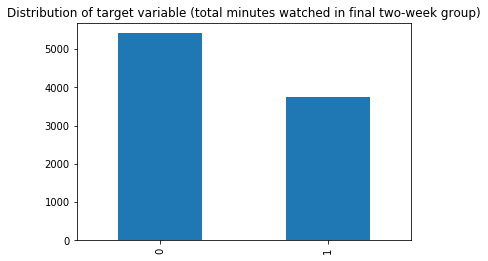

In [9]:
# Distribution of the dummy variable did the user watch or not
target_class[8].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of target variable (total minutes watched in final two-week group)')
plt.show()

In [10]:
# Ratio 
print("More precisely, "+
      str(round(sum(target_class[8])/len(target_class)*100,2))+
      "% of the users in our sample watched iPlayer within the last two-week period.")

More precisely, 40.9% of the users in our sample watched iPlayer within the last two-week period.


<a id='model_input'></a>
# Model Input

In this section we will walk through the process of how to select and calculate input to our model. The input to a statistical model can often be confusing as it can be described in many different ways. _Independent variables, explanatory variables, predictor variables_ and _features_ are all ways of describing the same thing: the input to your statistical model.

<a id='feature_selection'></a>
## Feature Selection
As mentioned in the first course, in most situations the process of selecting our input or __feature engineering__ is an iterative one until you get the feature set that neither “underfits” or “overfits” the data.

A feature set that does not contain sufficient information about the output variable will often result in the model underfitting (this can usually be identified by a high _training error_). The solution here is often to add more features. If the feature set contains features that are sensitive to spurious and random elements of the dataset (and not the underlying population it should be an approximation of), _overfitting_ occurs. Overfitting is characterised by low training error and high _test error_. Overfitting can be tackled by reducing the complexity of your model (often removing features) or using regularisation techniques (https://www.quora.com/What-is-regularization-in-machine-learning). A larger and more diverse training set also helps to reduce overfitting. We will come back to the concept of training and test erros in the following course.

There are various feature selection tools that can be used together with cross-validation to optimise your feature set (e.g. stepwise regression - https://en.wikipedia.org/wiki/Stepwise_regression).  
 
In our project we choose to focus on features that describe how the type viewing habits of a particular user (e.g. “average completion”, “most watched genre”, ”time watched“).

### User Granularity
The input variables for regression and classifications models are no different here, so we will perform the same process for each. Just like for our target variable, our input variables must to have a `user_id` granularity (i.e. each must be paired with a unique audience member).

N.B. As our dataset contains temporal properties, we could have performed a more granular pivot on `user_id x twoweek` (i.e. a user represented as seven rows - one for each two-week group). Splitting the dataset up in this way, allows certain types of model to exploit any temporal contingencies that may exist in the data. To keep things simple, here we stick to a single row per user.

In [11]:
# Create a function that pivots the data based on customer
# and gives us all the features we need
def pivot_data(dataframe):
    #How many minutes did each person watch in each 2 week period
    data=pd.pivot_table(dataframe,values='min_watched', 
                        index=['user_id'],columns=['twoweek'], aggfunc=sum)
    # Fill the weeks they didn't watch in with 0s
    data.fillna(0,inplace=True)
    # How much of average did each viewer watch?
    data['average_completion']=dataframe.groupby('user_id')['percentage_watched'].mean()
    # How many sessions did the person have with us
    data['total_sessions']=dataframe.groupby('user_id')['streaming_id'].nunique()
    # How many times has the viewer watched something
    data['number_watched']=dataframe.groupby('user_id')['streaming_id'].count()
    # Genre most watched by the viewer
    data['most_genre']=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],
                                      columns=['enriched_genre'], aggfunc=sum).idxmax(axis=1)
    # Number of genres watched
    data['num_genre']=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],
                                     columns=['enriched_genre'], aggfunc=sum).count(axis=1)
    # Favourite day of the week to watch
    data['most_weekday']=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],
                                        columns=['weekday'], aggfunc=sum).idxmax(axis=1)
    # Number of weekdays watched
    data['num_weekday']=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],
                                       columns=['weekday'], aggfunc=sum).count(axis=1)
    # Favorite time of day to watch
    data['most_timeday']=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],
                                        columns=['time_of_day'], aggfunc=sum).idxmax(axis=1)
    # Number of times of day
    data['num_timeday']=pd.pivot_table(dataframe,values='min_watched', index=['user_id'],
                                       columns=['time_of_day'], aggfunc=sum).count(axis=1)
    return data

In [12]:
# We need to consider here only the "past data", i.e. get rid of the last twoweek obs
# which corresponds to our target
features=pivot_data(data[data['twoweek']<8])
features.reset_index().head()

twoweek,user_id,1,2,3,4,5,6,7,average_completion,total_sessions,number_watched,most_genre,num_genre,most_weekday,num_weekday,most_timeday,num_timeday
0,0001c6,16.679200,0.000000,0.0000,0.000000,0.000000,0.152550,0.000000,0.371496,2,3,News,1,weekday_1,2,Evening,2
1,000c1a,0.162867,0.147467,107.0984,145.686233,2.286283,100.487767,132.432083,0.233136,28,38,Factual,5,weekday_3,6,Morning,3
2,001c53,1.866300,0.000000,0.0000,0.000000,1.309867,0.000000,0.000000,0.540923,3,3,News,2,weekday_2,2,Morning,2
3,001d44,0.000000,0.000000,0.0000,14.547700,0.000000,0.000000,0.248017,0.058203,2,3,Sport,2,weekday_6,1,Morning,2
4,002b2e,291.477033,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.230264,17,21,Factual,5,weekday_2,5,Evening,3


So now we have a set of features for each user. It currently includes:
- the minutes watched on a two-week basis for the past 14 weeks `1`, `2`,..., `7`

And aggregated over this 14 weeks timeframe:
- the average completion when watching a piece of content `average_completion`
- the number of sessions `total_sessions`
- the number of time a user watched something `number_watched`
- the main genre watched - in terms of minutes and not number of pieces of content - `most_genre`
- the number of different genre watched `num_genre`
- the favourite day of the week to watch - again in minutes watched - `most_weekday`
- the number of differents days of the week a user watched something - `num_weekday`
- the favourite time of the day to watch - again in minutes watched - `most_timeday`
- the number of differents times of the day a user watched something - `num_timeday`

This set of variables constitute our features space to build the models on. Each row in this table (without the userID) is referred to as a __feature vector__.  Note that we could have imagined lots of other features.

### Dummification
Most models only take in quantitative data. We therefore need to convert those that contain strings to categorical numeric representations. This process is often referred to as creating __dummy variables__. To do this we will replace each unique string within a categorical variable with an aditional column which can contain either a zero or a one.  

In [13]:
# Turn our categorical variables into bins so that we can run models on this
features=pd.get_dummies(features).reset_index()
features.head()

,user_id,1,2,3,4,5,6,7,average_completion,total_sessions,...,most_weekday_weekday_1,most_weekday_weekday_2,most_weekday_weekday_3,most_weekday_weekday_4,most_weekday_weekday_5,most_weekday_weekday_6,most_timeday_Afternoon,most_timeday_Evening,most_timeday_Morning,most_timeday_Night
0,0001c6,16.679200,0.000000,0.0000,0.000000,0.000000,0.152550,0.000000,0.371496,2,...,1,0,0,0,0,0,0,1,0,0
1,000c1a,0.162867,0.147467,107.0984,145.686233,2.286283,100.487767,132.432083,0.233136,28,...,0,0,1,0,0,0,0,0,1,0
2,001c53,1.866300,0.000000,0.0000,0.000000,1.309867,0.000000,0.000000,0.540923,3,...,0,1,0,0,0,0,0,0,1,0
3,001d44,0.000000,0.000000,0.0000,14.547700,0.000000,0.000000,0.248017,0.058203,2,...,0,0,0,0,0,1,0,0,1,0
4,002b2e,291.477033,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.230264,17,...,0,1,0,0,0,0,0,1,0,0


### Naming

Here we change the name of the columns representing the two-week minutes watched variables to make them generic:  `tw_lag7_watched`, `tw_lag5_watched`, ..., `tw_lag1_watched`.

If we want to use our model later for forecasting purposes on a new dataset with a new timeframe, this will make things much less confusing. 

In [14]:
# Make the column names generic
features = features.rename(columns={1:'tw_lag7_watched',
                                    2:'tw_lag6_watched',
                                    3:'tw_lag5_watched',
                                    4:'tw_lag4_watched',
                                    5:'tw_lag3_watched',
                                    6:'tw_lag2_watched',
                                    7:'tw_lag1_watched'})
features.head()

,user_id,tw_lag7_watched,tw_lag6_watched,tw_lag5_watched,tw_lag4_watched,tw_lag3_watched,tw_lag2_watched,tw_lag1_watched,average_completion,total_sessions,...,most_weekday_weekday_1,most_weekday_weekday_2,most_weekday_weekday_3,most_weekday_weekday_4,most_weekday_weekday_5,most_weekday_weekday_6,most_timeday_Afternoon,most_timeday_Evening,most_timeday_Morning,most_timeday_Night
0,0001c6,16.679200,0.000000,0.0000,0.000000,0.000000,0.152550,0.000000,0.371496,2,...,1,0,0,0,0,0,0,1,0,0
1,000c1a,0.162867,0.147467,107.0984,145.686233,2.286283,100.487767,132.432083,0.233136,28,...,0,0,1,0,0,0,0,0,1,0
2,001c53,1.866300,0.000000,0.0000,0.000000,1.309867,0.000000,0.000000,0.540923,3,...,0,1,0,0,0,0,0,0,1,0
3,001d44,0.000000,0.000000,0.0000,14.547700,0.000000,0.000000,0.248017,0.058203,2,...,0,0,0,0,0,1,0,0,1,0
4,002b2e,291.477033,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.230264,17,...,0,1,0,0,0,0,0,1,0,0


<a id='basic_statistics2'></a>
## Descriptive Statistics

As for the output variables, we can compute some basic statistics for our input ones.

### Distributions
We will first visualise their distributions by plotting histograms. There are 35 features in all so no time to look in into the details here, but you should notice that broadly speaking they should reflect the distributions we observed in the previous course.

#### Minutes watched per two-week group

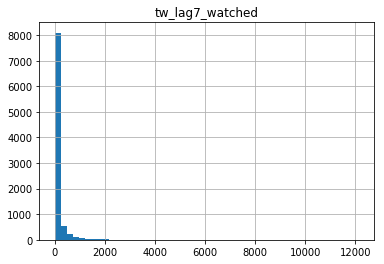

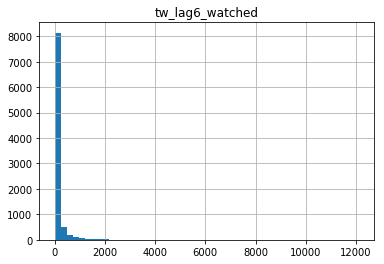

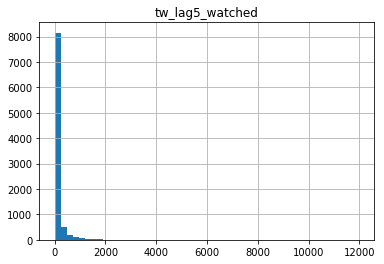

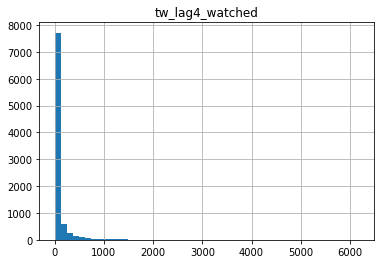

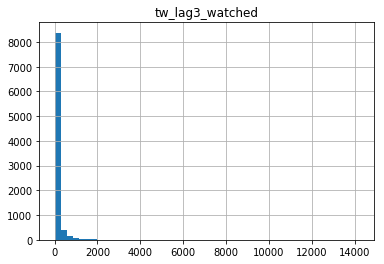

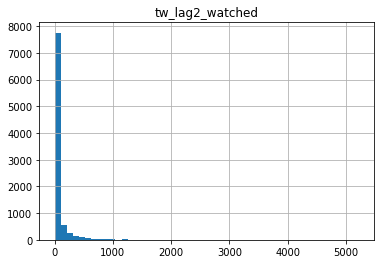

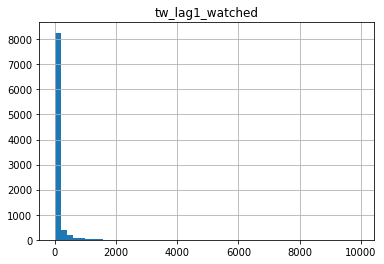

In [15]:
# Histogram 
for i in [x for x in list(features.columns) if 'tw_lag' in x]:
    features[i].hist(bins=50)
    plt.title(i)
    plt.show()

These distributions underline __different levels of engagement__ within the users on this two-week timeframe.


#### Total number of sessions over the entire timeframe

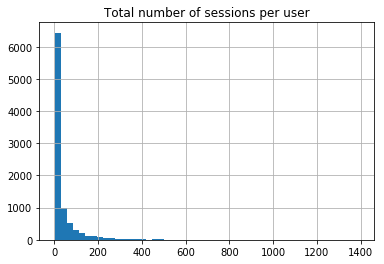

In [16]:
# Histogram
features['total_sessions'].hist(bins=50)
plt.title('Total number of sessions per user')
plt.show()

#### Number of unique pieces of content watched over the entire timeframe

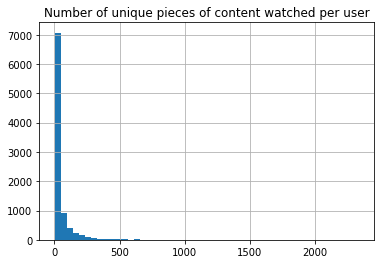

In [17]:
# Histogram
features['number_watched'].hist(bins=50)
plt.title('Number of unique pieces of content watched per user')
plt.show()

#### Average completion over the entire timeframe

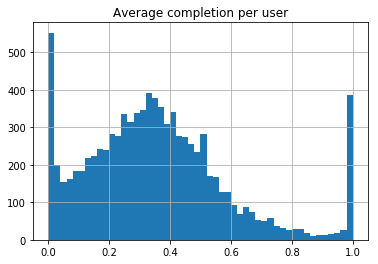

In [18]:
# Histogram
features['average_completion'].hist(bins=50)
plt.title('Average completion per user')
plt.show()

#### Diversity in the consumption of iPlayer

We will have a look here at the distribution of the following variables:
- `num_genre`: number of different genre watched over the entire timeframe
- `num_weekday`: number of different days of the week the user watched iPlayer over the entire timeframe
- `num_timeday`: number of different time of the day the user watched iPlayer over the entire timeframe

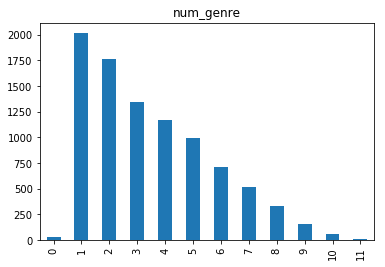

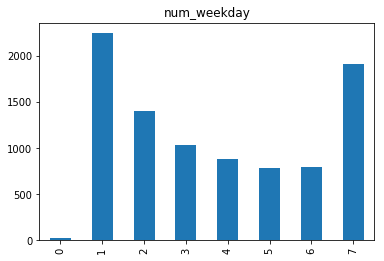

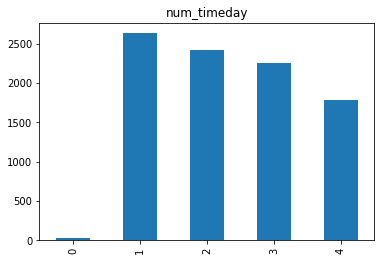

In [19]:
# Histogram 
for i in ['num_genre', 'num_weekday','num_timeday']:
    features[i].value_counts().sort_index().plot(kind='bar')
    plt.title(i)
    plt.show()

Remark: for few users these variables are null. These users only have observations for the last two-week group that we are not considering here. So we have null rows in our feature space. We will get rid of them later in the course. 

#### Favourite genre over the entire timeframe

In [20]:
# Let's merge the different dummies related to the favourite genre
# in order to have only one histogram 
favourite_genre=dict()
for i in [x for x in list(features.columns) if 'most_genre' in x]:
    favourite_genre[i.split('most_genre_',1)[1]]=sum(features[i]) 
pd.Series(favourite_genre)

Children's            336
Comedy                513
Drama                2623
Entertainment         562
Factual              2816
Learning               43
Music                  96
News                  776
Religion & Ethics      18
Sport                1234
Weather                61
dtype: int64

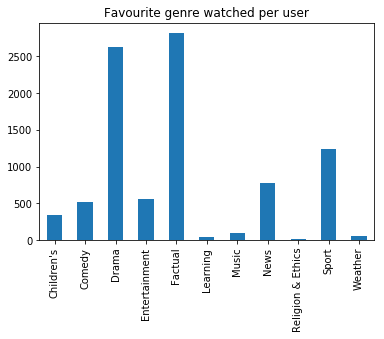

In [21]:
# Histogram
pd.Series(favourite_genre).sort_index().plot(kind='bar')
plt.title('Favourite genre watched per user')
plt.show()

#### Favourite day of the week over the entire timeframe

In [22]:
# Let's merge the different dummies related to the favourite day of week
# in order to have only one histogram 
favourite_weekday=dict()
for i in [x for x in list(features.columns) if 'most_weekday' in x]:
    favourite_weekday[i.split('most_weekday_',1)[1]]=sum(features[i]) 
pd.Series(favourite_weekday)

weekday_0    1423
weekday_1    1217
weekday_2    1119
weekday_3     927
weekday_4    1025
weekday_5    1415
weekday_6    1952
dtype: int64

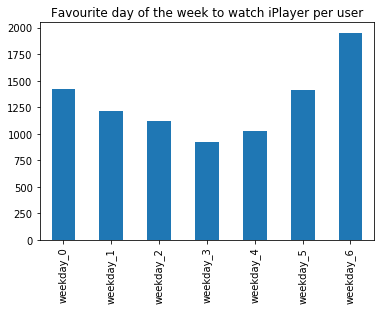

In [23]:
# Histogram
pd.Series(favourite_weekday).sort_index().plot(kind='bar')
plt.title('Favourite day of the week to watch iPlayer per user')
plt.show()

#### Favourite time of the day over the entire timeframe

In [24]:
# Let's merge the different dummies related to the favourite time of the day
# in order to have only one histogram 
favourite_timeday=dict()
for i in [x for x in list(features.columns) if 'most_timeday' in x]:
    favourite_timeday[i.split('most_timeday_',1)[1]]=sum(features[i]) 
pd.Series(favourite_timeday)

Afternoon    2133
Evening      4068
Morning      1936
Night         941
dtype: int64

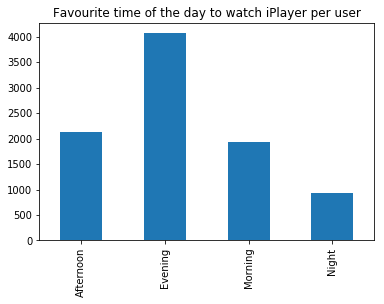

In [25]:
# Histogram
pd.Series(favourite_timeday).sort_index().plot(kind='bar')
plt.title('Favourite time of the day to watch iPlayer per user')
plt.show()

As expected, we don't learn much more compared to the descriptive exploratory of last course. Nervertheless it is a mandatory sanity check and it can sometimes allow to spot outliers at the _user level_.

### Visualising the Relationships between Features

A __correlation matrix__ is a good way of getting a quick grasp of the relationships between our features. Correlation is a statistical test which measures the strength of a linear relationship between two variables. The correlation coefficient is a value between -1 and 1. Variables that are perfectly correlated or peerfectly inversely-correlated  have coefficients of 1 and -1 respectively. Variables that have no linear relationship will have a coeffient of zero. A correlation matrix calculates coefficients for every pair of variable and illustrates them n x n grid (where n= the number of features). 

For many models (_regressions_ for example) we have to avoid multicolinearity in our features space. If input variables are correlated some assumptions in the modelling framework won't hold anymore and it will result in inaccurate results. 

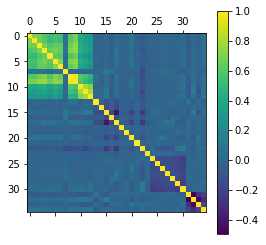

In [26]:
# Correlation matrix
plt.matshow(features.corr())
plt.colorbar()
plt.show()

In [27]:
# Reminder on the different input variables 
input_var=dict()
i=0
for x in features.columns:
    input_var[i]=x
    i+=1
input_var

{0: 'user_id',
 1: 'tw_lag7_watched',
 2: 'tw_lag6_watched',
 3: 'tw_lag5_watched',
 4: 'tw_lag4_watched',
 5: 'tw_lag3_watched',
 6: 'tw_lag2_watched',
 7: 'tw_lag1_watched',
 8: 'average_completion',
 9: 'total_sessions',
 10: 'number_watched',
 11: 'num_genre',
 12: 'num_weekday',
 13: 'num_timeday',
 14: "most_genre_Children's",
 15: 'most_genre_Comedy',
 16: 'most_genre_Drama',
 17: 'most_genre_Entertainment',
 18: 'most_genre_Factual',
 19: 'most_genre_Learning',
 20: 'most_genre_Music',
 21: 'most_genre_News',
 22: 'most_genre_Religion & Ethics',
 23: 'most_genre_Sport',
 24: 'most_genre_Weather',
 25: 'most_weekday_weekday_0',
 26: 'most_weekday_weekday_1',
 27: 'most_weekday_weekday_2',
 28: 'most_weekday_weekday_3',
 29: 'most_weekday_weekday_4',
 30: 'most_weekday_weekday_5',
 31: 'most_weekday_weekday_6',
 32: 'most_timeday_Afternoon',
 33: 'most_timeday_Evening',
 34: 'most_timeday_Morning',
 35: 'most_timeday_Night'}

In the correlation matrix of our input features above,  we can infer that there is a strong linear relationship between `total_sessions` and `number_watched`. We decide to remove `number_watched` for the rest of the analysis. Some other variables are highly correlated but not to that extent so we will keep them. 

Correlation matrix is then useful in the feature selection process. It helps __identify redundancy__ between your features and therefore identify candidates for removal when needing to reduce complexity.  

In [28]:
features=features.drop(['number_watched'], axis=1)

<a id='pair_input_output'></a>
# Pair Model Input with Model Output

Now we need to ensure that our input variables match up with our output variable. Each row in our input table should match up to the same `user_id` in our output table. If features or target values are missing for a given user we will get rid of this observation.

In [29]:
# Find the unique users in both the features and the target
users_target=target_reg['user_id'].unique()
users_features=features['user_id'].unique()

# Find those users that are in the target but not in the feature
target_not_feature=[]
for user in users_target:
    if user not in users_features:
        target_not_feature.append(user)

# Find those users that are in the feature but not in the target
feature_not_target=[]
for user in users_features:
    if user not in users_target:
        feature_not_target.append(user)

# Print the size of the two sets
print('In target but not feature:',len(target_not_feature),
      '- In feature but not target:' ,len(feature_not_target))

In target but not feature: 56 - In feature but not target: 0


Remark: it's actually normal to have no one missing in the second case because we built the target variables based on the entire population of the training data. It's more a sanity check here.

We need to remove any users that don't have recorded viewing behaviour before `twoweek` 8. These users can be explained in two ways: either they did not consume any content in the first seven two-week groups or they only signed up to iPlayer in the final two-week group. Neither of these groups are useful from a modeling perspective so we will remove them all. 

N.B A `time_since_account_created` variable could be an informative feature to consider in a future model. However, we might need some "business" logic to avoid what is often referred to as __left-censoring__ issues: i.e. as we can't usually observe the entire historic, it's often difficult to have a signing date for all users. We might have began the tracking of our data after the first user accounts.

In [30]:
# We will set the index to the user_id as this will make it easier to drop rows
# Then we drop the rows and then turn the remaining column into an array
target_reg=target_reg.set_index(['user_id'])
target_reg.drop(target_not_feature,inplace=True)
target_reg.reset_index(inplace=True)
target_reg=target_reg[8].values

# Same for the classification
target_class=target_class.set_index(['user_id'])
target_class.drop(target_not_feature,inplace=True)
target_class.reset_index(inplace=True)
target_class=target_class[8].values
        
# Check to make sure the outcome makes sense
print(target_reg[:10])
print(target_class[:10])

[  1.44833333e-01   3.18047633e+02   1.98035000e+00   1.00590667e+01
   0.00000000e+00   4.79261667e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
[1 1 1 1 0 1 0 0 0 0]


In [31]:
# Let's check the size of our datasets
print('Number of samples in the training feature set:',len(features))
print('Number of samples in the training target set (classification):',
      len(target_class))
print('Number of samples in the training target set (regression):',
      len(target_reg))

Number of samples in the training feature set: 9107
Number of samples in the training target set (classification): 9107
Number of samples in the training target set (regression): 9107


<a id='missing_data'></a>
# Check for Missing Data

The last thing we need to do is to replace any possible missing values with zeros and remove the `user_id` field from each row. This field contains useful information for indexing but it does not contain useful modeling information. Therefore, we shall move it from a normal column to an index column.

In [32]:
# We will fill remaining missing values with 0s as we don't know any better
features=features.set_index(['user_id'])
features.fillna(0,inplace=True)
features.head()

,tw_lag7_watched,tw_lag6_watched,tw_lag5_watched,tw_lag4_watched,tw_lag3_watched,tw_lag2_watched,tw_lag1_watched,average_completion,total_sessions,num_genre,...,most_weekday_weekday_1,most_weekday_weekday_2,most_weekday_weekday_3,most_weekday_weekday_4,most_weekday_weekday_5,most_weekday_weekday_6,most_timeday_Afternoon,most_timeday_Evening,most_timeday_Morning,most_timeday_Night
user_id,,,,,,,,,,,,,,,,,,,,,
0001c6,16.679200,0.000000,0.0000,0.000000,0.000000,0.152550,0.000000,0.371496,2,1,...,1,0,0,0,0,0,0,1,0,0
000c1a,0.162867,0.147467,107.0984,145.686233,2.286283,100.487767,132.432083,0.233136,28,5,...,0,0,1,0,0,0,0,0,1,0
001c53,1.866300,0.000000,0.0000,0.000000,1.309867,0.000000,0.000000,0.540923,3,2,...,0,1,0,0,0,0,0,0,1,0
001d44,0.000000,0.000000,0.0000,14.547700,0.000000,0.000000,0.248017,0.058203,2,2,...,0,0,0,0,0,1,0,0,1,0
002b2e,291.477033,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.230264,17,5,...,0,1,0,0,0,0,0,1,0,0


 Now that we have our data in the perfect condition to ingest into a statistical model, we shall save it on disk so that we can continue working on it in the next course.

In [33]:
features.to_csv('features.csv')
np.savetxt('target.txt',(target_reg,target_class))

# Summary

In this course we looked at the process of preparing our dataset to be ingested into a statistical model.

- We learnt about how data should be prepared in different ways based upon the kind of problem you have (supervised or unsupervised) and the kind of model you intend to use (classification or regression).
- We learnt that for supervised learning problems, input/output pairs need to be calculated from our original dataset. 
- We learnt about useful tools such as the generation of pivot tables that helps translate our dataset from event-centered rows to user-centered rows.

Next course we will start the modelling part.